#  Pre-work Dirichlet distribution

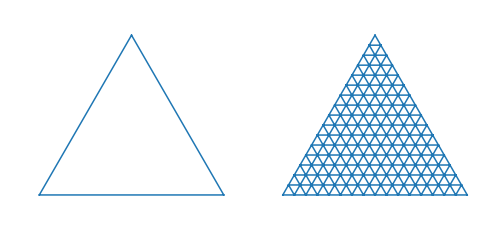

In [10]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from functools import reduce
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')

In [11]:
# Mid-points of triangle sides opposite of each corner
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

In [12]:
class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

In [13]:
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

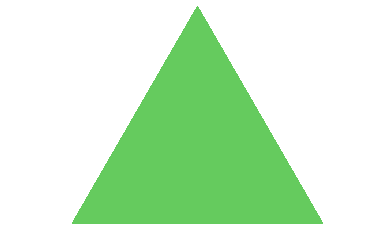

In [14]:
draw_pdf_contours(Dirichlet([1, 1, 1]))

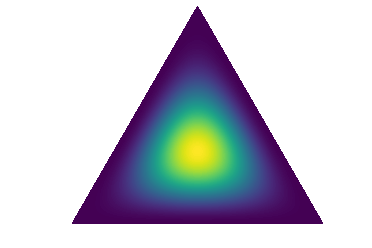

In [19]:
draw_pdf_contours(Dirichlet([10/3, 10/3, 10/3]))

# Pre-work Dirichlet process

In [43]:
import numpy as np
from scipy.stats import dirichlet
np.set_printoptions(precision=2)

def stats(scale_factor, G0=[.2, .2, .6], N=10000):
    samples = dirichlet(alpha = scale_factor * np.array(G0)).rvs(N)
    print("                          alpha:", scale_factor)
    print("              element-wise mean:", samples.mean(axis=0))
    print("element-wise standard deviation:", samples.std(axis=0))
    print()
    
for scale in [0.1, 1, 10, 100, 1000]:
    stats(scale)

                          alpha: 0.1
              element-wise mean: [0.2 0.2 0.6]
element-wise standard deviation: [0.38 0.38 0.47]

                          alpha: 1
              element-wise mean: [0.19 0.2  0.61]
element-wise standard deviation: [0.28 0.28 0.34]

                          alpha: 10
              element-wise mean: [0.2 0.2 0.6]
element-wise standard deviation: [0.12 0.12 0.15]

                          alpha: 100
              element-wise mean: [0.2 0.2 0.6]
element-wise standard deviation: [0.04 0.04 0.05]

                          alpha: 1000
              element-wise mean: [0.2 0.2 0.6]
element-wise standard deviation: [0.01 0.01 0.02]



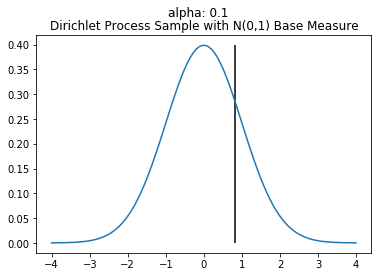

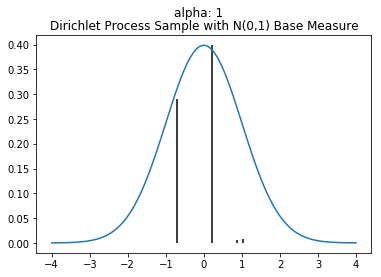

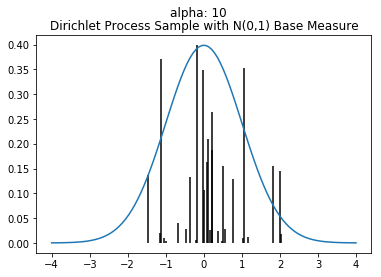

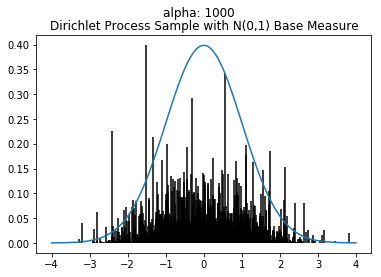

In [44]:
import matplotlib.pyplot as plt
from scipy.stats import beta, norm

def dirichlet_sample_approximation(base_measure, alpha, tol=0.01):
    betas = []
    pis = []
    betas.append(beta(1, alpha).rvs())
    pis.append(betas[0])
    while sum(pis) < (1.-tol):
        s = np.sum([np.log(1 - b) for b in betas])
        new_beta = beta(1, alpha).rvs() 
        betas.append(new_beta)
        pis.append(new_beta * np.exp(s))
    pis = np.array(pis)
    thetas = np.array([base_measure() for _ in pis])
    return pis, thetas

def plot_normal_dp_approximation(alpha):
    plt.figure()
    plt.title("Dirichlet Process Sample with N(0,1) Base Measure")
    plt.suptitle("alpha: %s" % alpha)
    pis, thetas = dirichlet_sample_approximation(lambda: norm().rvs(), alpha)
    pis = pis * (norm.pdf(0) / pis.max())
    plt.vlines(thetas, 0, pis, )
    X = np.linspace(-4,4,100)
    plt.plot(X, norm.pdf(X))

plot_normal_dp_approximation(.1)
plot_normal_dp_approximation(1)
plot_normal_dp_approximation(10)
plot_normal_dp_approximation(1000)

In [45]:
from numpy.random import choice

class DirichletProcessSample():
    def __init__(self, base_measure, alpha):
        self.base_measure = base_measure
        self.alpha = alpha
        
        self.cache = []
        self.weights = []
        self.total_stick_used = 0.

    def __call__(self):
        remaining = 1.0 - self.total_stick_used
        i = DirichletProcessSample.roll_die(self.weights + [remaining])
        if i is not None and i < len(self.weights) :
            return self.cache[i]
        else:
            stick_piece = beta(1, self.alpha).rvs() * remaining
            self.total_stick_used += stick_piece
            self.weights.append(stick_piece)
            new_value = self.base_measure()
            self.cache.append(new_value)
            return new_value
        
    @staticmethod 
    def roll_die(weights):
        if weights:
            return choice(range(len(weights)), p=weights)
        else:
            return None

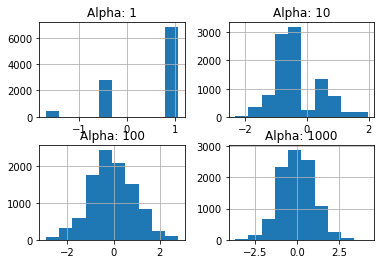

In [46]:
import pandas as pd

base_measure = lambda: norm().rvs()
n_samples = 10000
samples = {}
for alpha in [1, 10, 100, 1000]:
    dirichlet_norm = DirichletProcessSample(base_measure=base_measure, alpha=alpha)
    samples["Alpha: %s" % alpha] = [dirichlet_norm() for _ in range(n_samples)]

_ = pd.DataFrame(samples).hist()

#  LDA application on documents 

In [39]:
doc1 = "Mcgrady is basketball player."
doc2 = "Kobe likes to play basketball.."
doc3 = "NBA is a association for basketball."
doc4 = "James can dunk and shoot."
doc5 = "Curry has a good ability to shoot."

# 整合文档数据
doc_complete = [doc1, doc2, doc3, doc4, doc5]


In [40]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
import gensim
from gensim import corpora

# 创建语料的词语词典，每个单独的词语都会被赋予一个索引
dictionary = corpora.Dictionary(doc_clean)

# 使用上面的词典，将转换文档列表（语料）变成 DT 矩阵
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]


In [44]:
# 使用 gensim 来创建 LDA 模型对象
Lda = gensim.models.ldamodel.LdaModel

# 在 DT 矩阵上运行和训练 LDA 模型
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=150)


In [45]:
# 输出结果
print(ldamodel.print_topics(num_topics=3, num_words=3))


[(0, '0.200*"shoot" + 0.114*"curry" + 0.114*"good"'), (1, '0.174*"player" + 0.174*"mcgrady" + 0.173*"basketball"'), (2, '0.200*"basketball" + 0.114*"like" + 0.114*"play"')]


In [38]:
print(dictionary)

Dictionary(35 unique tokens: ['driving', 'practice', 'stress', 'school', 'perform']...)


#  Test on my data(From class IFT 6269 hwk3 in McGill University)

Populating the interactive namespace from numpy and matplotlib


d:\python35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


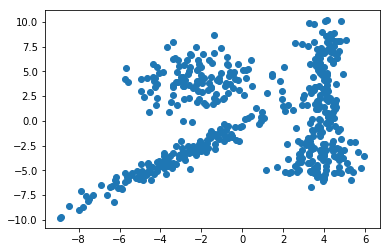

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import multivariate_normal
%pylab inline

train = pd.DataFrame(pd.read_csv('G:\jupyter\hwk3data\EMGaussian.train',sep='\s+',header=None))
train.columns = ['a', 'b']
# print(train)
n = train.shape[0]
plt.scatter(train.iloc[:,0],train.iloc[:,1])
plt.show()

{0, 1, 2}


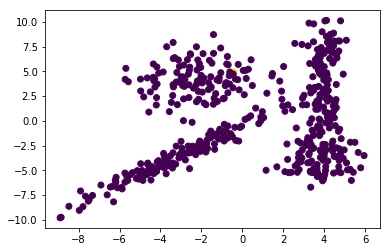

In [40]:
# self-made
c=[]
cluster={}
alpha=1.


for i in range(n):
    if i==0:
        c.append(0)
        cluster[0]=1
    else:
        prob1 = alpha/(alpha+i+1-1)
        isnew=np.random.binomial(1, alpha/(alpha+i+1-1), 1)
        if isnew[0]==1:
            c.append(max(c)+1)
        else:
            probs=[]
            for key,value in cluster.items():
                probs.append(value)
            norm_base = sum(probs)
            probs_norm = [p*1.0/norm_base for p in probs]
            c_ = np.random.multinomial(1, probs_norm, size=1).reshape(-1) .tolist().index(1)
            c.append(c_)
            
train['clusters']=c
print(set(c))
plt.scatter(train.iloc[:,0],train.iloc[:,1],c=c)
plt.show()

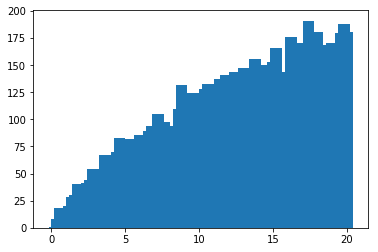

In [42]:
cluster_num_list = []
alpha_list = []
a=0.2

for i in range(100):
    alpha_list.append(a)
    a+=0.2
    
for alpha in range(len(alpha_list)):
    c = []
    cluster={}
    for i in range(n):
        if i==0:
            c.append(0)
            cluster[0]=1
        else:
            prob1 = alpha/(alpha+i+1-1)
            isnew=np.random.binomial(1, alpha/(alpha+i+1-1), 1)
            if isnew[0]==1:
                c.append(max(c)+1)
            else:
                probs=[]
                for key,value in cluster.items():
                    probs.append(value)
                norm_base = sum(probs)
                probs_norm = [p*1.0/norm_base for p in probs]
                c_ = np.random.multinomial(1, probs_norm, size=1).reshape(-1) .tolist().index(1)
                c.append(c_)
    cluster_num_list.append(len(set(c)))
plt.bar(alpha_list,cluster_num_list)
plt.show()